# A few useful things to know about machine learning - Pedro Domingos

Some claims to explore: <i>Intuition Fails in High Dimensions</i>

> "Consider a nearest neighbor classifier with Hamming distance as the similarity measure, and sup- pose the class is just x1 ∧ x2. If there are no other features, this is an easy problem. But if there are 98 irrelevant features x3,..., x100, the noise from them completely swamps the signal in x1 and x2, and nearest neighbor effectively makes random predictions." - p5

> "Even more disturbing is that nearest neighbor still has a problem even if all 100 features are relevant!" - p5

[The failure of nearest neighbors](#knnfail) 

[Counterintuition](#counter)

I originally though the curse of dimensionality was mostly about increasing complexity, but proving this below, irrelevant features and noise makes metric-based learning completely random. We will also try to take a look at how [multivariate gaussians, oranges, and hypercubes] are distributed. Hint: not how you think.

[Blessing of Non-Uniformity](#BoNU)

The silver lining is the <i>blessing of non-uniformity</i>, which refers to the phenomenon that any low-dimensional manifold holding this data has the points very close to each other relative to the entire space. 

> ".. the space of digit images is much smaller than the space of all possible images" - p6

Follow-up:
- What about redundant features? 
- Why doesn't our KNN do much worse when we sample close to the classes?

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

<a name="knnfail"><h2>Generate x1 AND x2 data with x3 to xn as noise</h2></a>

In [18]:
def generateY(x):
    return x[0] and x[1]

## How does noise generated affect performance?

- 

In [19]:
# generate dataset show how noise dimension SWAMPS
iterations = 10
#length = 300
dimensions = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
#dimensions = dimensions[:3]
data_size = 100

test_acc_avg = []


for d in dimensions[:]:
    cm = []
    test_acc = []
    for i in range(iterations):
        data_x1 = np.random.randint(2, size=(data_size, 2))
        #data_x2 = np.random.random((data_size, d-2))*2 -1 # with noise -1 to 1 # FIRST 
        data_x2 = np.random.random((data_size, d-2))*2-1 # especially if those features are larger than our context  #FOURTH
        
        
        #data_x2 = np.random.normal(np.random.randint(2), 0, (data_size, 1)) #+ np.random.normal(1, 0.1, (data_size, d-2)) # mixture of gaussians, should be generative model with coin-flips! 
        # even with this generative model? Interesting
        """
        data_x2 = []
        
        for s in range(data_size):
            temp = []
            for c in range(d-2):
                temp.append(np.random.normal(np.random.randint(2), 0.1))
            data_x2.append(temp)
            
        data_x2 = np.array(data_x2)
            
            #data_x2 = np.concatenate((data_x2, temp), axis=1)
        """
        #data_x2 = np.zeros((data_size, d-2)) # SECOND 
        #data_x2 = np.random.randint(2, size=(data_size, d-2)) # with randoms 0 to 1 #THIRD 
        data_x = np.concatenate((data_x1, data_x2), axis=1)
        
        data_y = np.array([generateY(x) for x in data_x])
        
        # Add even more noise to our x1 ^ x2
        #data_x[:,:2] += np.random.normal(0, 0.1, (data_size, 2))

        X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.5, random_state=43)
        neigh = KNeighborsClassifier(n_neighbors=1)
        neigh.fit(X_train, y_train)

        y_pred_t = neigh.predict(X_train)
        #print("Train acc: ", accuracy_score(y_pred_t, y_train))
        y_pred = neigh.predict(X_test)
        cm_i = confusion_matrix(y_pred, y_test)
        if i == 0:
            print(cm_i)
        test_acc_i = balanced_accuracy_score(y_pred, y_test)
        #print("Test acc: ", test_acc_i)
        cm.append(cm_i)
        test_acc.append(test_acc_i)
    test_acc_avg_i = np.average(test_acc)
    print("Dimensions: ", d, " test_acc_avg: ", test_acc_avg_i)
    test_acc_avg.append(test_acc_avg_i)

[[36  0]
 [ 0 14]]
Dimensions:  2  test_acc_avg:  1.0
[[32  0]
 [ 1 17]]
Dimensions:  4  test_acc_avg:  0.9960027100271003
[[34  3]
 [ 1 12]]
Dimensions:  8  test_acc_avg:  0.8721989500298324
[[34  8]
 [ 2  6]]
Dimensions:  16  test_acc_avg:  0.6796367301772659
[[32  6]
 [ 6  6]]
Dimensions:  32  test_acc_avg:  0.6503265339342734
[[33  4]
 [ 7  6]]
Dimensions:  64  test_acc_avg:  0.5471360187929586
[[27  8]
 [ 8  7]]
Dimensions:  128  test_acc_avg:  0.570064068376288
[[28  9]
 [11  2]]
Dimensions:  256  test_acc_avg:  0.5346084018548565
[[24 11]
 [11  4]]
Dimensions:  512  test_acc_avg:  0.5383244390458547
[[27 11]
 [10  2]]
Dimensions:  1024  test_acc_avg:  0.5187390816538466
[[34  8]
 [ 5  3]]
Dimensions:  2048  test_acc_avg:  0.5249264862057854


In [20]:
# T-SNE this! Makes no sense.
data_x

array([[ 1.        ,  0.        ,  0.67765007, ..., -0.79238709,
        -0.03872025,  0.71862928],
       [ 1.        ,  0.        , -0.4924143 , ...,  0.93842979,
         0.23268684,  0.65110138],
       [ 0.        ,  1.        ,  0.91929735, ...,  0.7714898 ,
        -0.89876803, -0.94037494],
       ...,
       [ 1.        ,  0.        , -0.32520266, ...,  0.11743338,
        -0.36259587, -0.4860141 ],
       [ 0.        ,  1.        ,  0.88220971, ..., -0.40597811,
        -0.26143041,  0.87089519],
       [ 0.        ,  0.        , -0.33415045, ...,  0.29984788,
        -0.58447604,  0.28513308]])

## Note that we use balanced accuracy because our dataset is imbalanced (75% class 0, 25% class 1)

Text(0.5, 1.0, 'How additional noisy features affect kNN accuracy in binary problem')

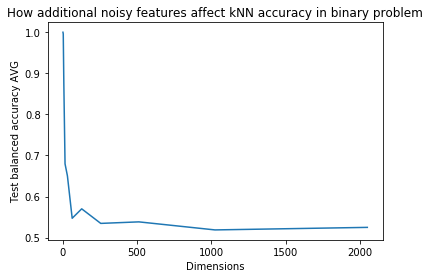

In [21]:
plt.plot(dimensions, test_acc_avg)
plt.xlabel("Dimensions")
plt.ylabel("Test balanced accuracy AVG")
plt.xscale("linear")
plt.title("How additional noisy features affect kNN accuracy in binary problem")

## The performance degradation is rather dramatic

Text(0.5, 1.0, 'How additional noisy features affect kNN accuracy in binary problem')

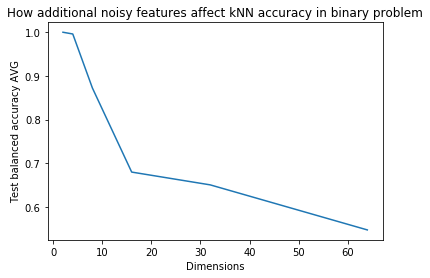

In [22]:
plt.plot(dimensions[:6], test_acc_avg[:6])
plt.xlabel("Dimensions")
plt.ylabel("Test balanced accuracy AVG")
plt.xscale("linear")
plt.title("How additional noisy features affect kNN accuracy in binary problem")


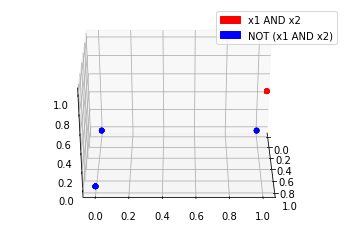

In [23]:
# split up scatters
# sample it rather than this. 
# Visualize 3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

data_x_c1 = np.array([x for x,y in zip(data_x, data_y) if y == 1])
data_x_c2 = np.array([x for x,y in zip(data_x, data_y) if y == 0])
ax.scatter(xs=data_x_c1[:,:1], ys=data_x_c1[:,1:2], zs=np.ones(len(data_x_c1)), color='red')
ax.scatter(xs=data_x_c2[:,:1], ys=data_x_c2[:,1:2], zs=np.zeros(len(data_x_c2)), color='blue')
red_patch = mpatches.Patch(color='red', label='x1 AND x2')
blue_patch = mpatches.Patch(color='blue', label='NOT (x1 AND x2)')
ax.legend(handles=[red_patch, blue_patch])
ax.view_init(30, 0)

## Demonstrated below: it looks like up to 3D we can still achieve 100% Accuracy (depending on how our noise is generated) with x = y. 
With more dimensions, the noise can make nearest neighbors not make sense anymore.

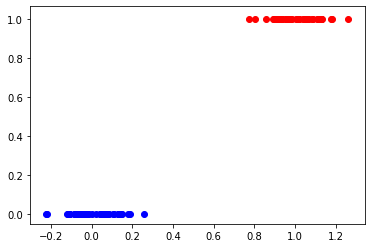

In [24]:
# Distances to it are all the same when you look at it even when relevant?
# scale up 2D to 3D, show that the 3D 
# adding the Z-dimension does this. 
data_x = np.random.randint(2, size=(100)).astype(float)
data_y = np.array([x for x in data_x])

# add a bit of noise for visualization
data_x += np.random.normal(0, 0.1, (100,))

data_x_c1 = np.array([x for x,y in zip(data_x, data_y) if y == 1])
data_x_c2 = np.array([x for x,y in zip(data_x, data_y) if y == 0])

plt.scatter(data_x_c1, np.ones(len(data_x_c1)), color='red')
plt.scatter(data_x_c2, np.zeros(len(data_x_c2)), color='blue')
plt.show()
# XOR?
# taking subset of features matters!

In [25]:
# let's add a third dimension. How noise swamps 2D to 3D 
data_x1 = np.random.randint(2, size=(100, 1)).astype(float)
data_x2 = np.random.randint(2, size=(100, 1))#np.random.random((100, 1))*2 -1
data_y = np.array([x[0] for x in data_x1])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

data_x1 += np.random.normal(0, 0.1, (100, 1))

data_x = np.concatenate((data_x1, data_x2), axis=1)

data_x_c1 = np.array([x for x,y in zip(data_x, data_y) if y == 1])
data_x_c2 = np.array([x for x,y in zip(data_x, data_y) if y == 0])

# print(np.shape(data_x_c1))
ax.scatter(xs=data_x_c1[:,:1], ys=data_x_c1[:,1:2], zs=np.ones(len(data_x_c1)), color='red')
ax.scatter(xs=data_x_c2[:,:1], ys=data_x_c2[:,1:2], zs=np.zeros(len(data_x_c2)), color='blue')
red_patch = mpatches.Patch(color='red', label='x1 AND x2')
blue_patch = mpatches.Patch(color='blue', label='NOT (x1 AND x2)')
ax.legend(handles=[red_patch, blue_patch])

ax.view_init(30, 90)


<a name="BoNU"> <h2>Let's show that in a high-dimensional space like an image, the images of interest that we care about lie on a low-D manifold<h2> </a>
Note: if you randomly generate pixels in this dimension, you will only ever get static



In [26]:
from sklearn.datasets import load_digits
import cv2 
digits = load_digits()

In [27]:
seven = digits.images[7]

In [28]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

# What about translations?

# what about zoom out and in? 

In [29]:
sevens_rotated = np.array([rotate_image(seven, x) for x in range(0, 360)])

In [30]:
sevens_rotated_reshape = np.reshape(sevens_rotated, (len(sevens_rotated), 8*8))

In [157]:
pca = PCA(n_components=2, svd_solver='arpack')
transformed = pca.fit_transform(sevens_rotated_reshape)
print(pca.explained_variance_ratio_)

[0.21076772 0.19935402]


In [135]:
from sklearn.manifold import TSNE
sevens_rotated_tsne = TSNE(n_components=3).fit_transform(sevens_rotated_reshape)


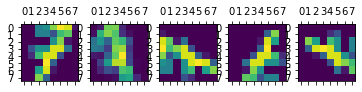

In [33]:
fig = plt.figure()
for i, angle in enumerate([0, 45, 90, 180, 270]):
    ax = fig.add_subplot(1, 5, i+1)
    ax.matshow(sevens_rotated[angle])


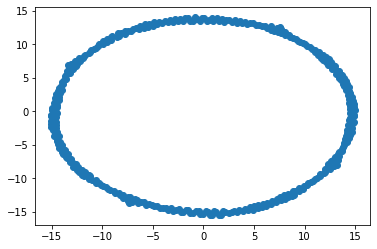

In [34]:
plt.scatter(sevens_rotated_tsne[:,0:1], sevens_rotated_tsne[:,1:2])

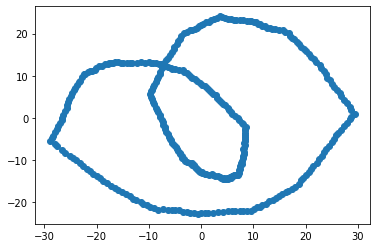

In [35]:
plt.scatter(transformed[:,:1], transformed[:,1:2])

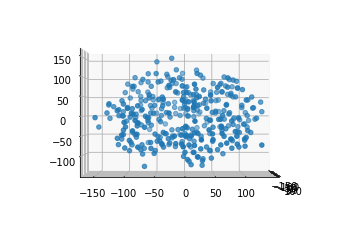

In [136]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=sevens_rotated_tsne[:,:1], ys=sevens_rotated_tsne[:,1:2], zs=sevens_rotated_tsne[:,2:])
ax.view_init(0, 0)

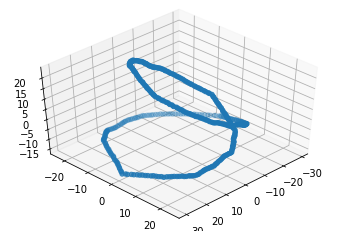

In [137]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=transformed[:,:1], ys=transformed[:,1:2], zs=transformed[:,2:])
ax.view_init(45, 45)

In [138]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()


In [139]:
np.shape(faces.images)

(400, 64, 64)

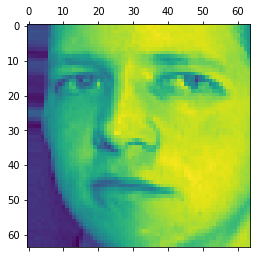

In [140]:
plt.matshow(faces.images[3])

In [159]:
pca = PCA(n_components=2, svd_solver='arpack')
transformed = pca.fit_transform(faces.data)
print(pca.explained_variance_ratio_)

[0.2381273  0.13993974]


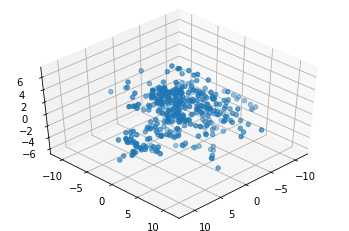

In [148]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=transformed[:,:1], ys=transformed[:,1:2], zs=transformed[:,2:])
ax.view_init(45, 45)

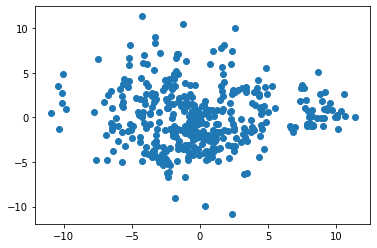

In [150]:
plt.scatter(transformed[:,:1], transformed[:,1:2])

In [154]:
# what about a TSNE? Is PC the only way?
#face_tsne = TSNE(n_components=2).fit(faces.data)
faces_tsne = TSNE(n_components=2).fit_transform(faces.data)

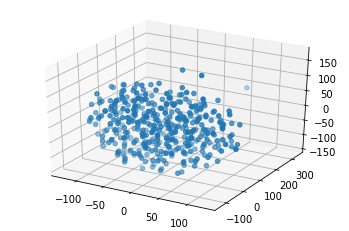

In [153]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=faces_tsne[:,:1], ys=faces_tsne[:,1:2], zs=faces_tsne[:,2:])

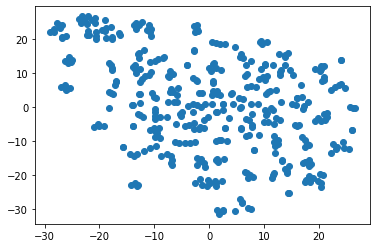

In [155]:
plt.scatter(faces_tsne[:,:1], faces_tsne[:,1:])

## Inversely draw from this low-dimensional manifold.

In [160]:
#pca.inverse_transform
x_min = min(transformed[:, :1])
x_max = max(transformed[:, :1])
y_min = min(transformed[:, 1:2])
y_max = max(transformed[:, 1:2])

x = np.random.uniform(x_min, x_max, (100, 1))
y = np.random.uniform(y_min, y_max, (100, 1))
sample = np.concatenate((x, y), axis=1)
#print(sample)

inverse_samples = pca.inverse_transform(sample)
inverse_samples_reshaped = np.reshape(inverse_samples, (100, 64, 64))


In [161]:
np.shape(inverse_samples)

(100, 4096)

<Figure size 432x288 with 0 Axes>

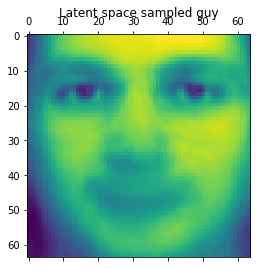

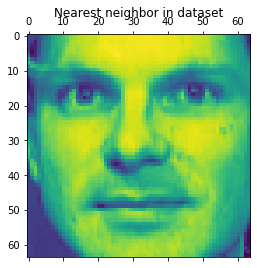

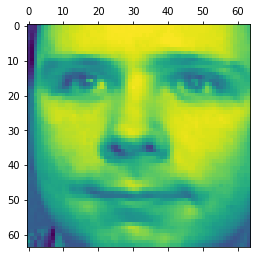

In [163]:
# try your nearest neighbor!
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(faces.data)
distances, indices = nbrs.kneighbors(inverse_samples)
fig = plt.figure()

#ax = fig.add_subplot('12' + str(i+1))
plt.matshow(inverse_samples_reshaped[6])
#ax = fig.add_subplot('12' + str(i+2))
plt.title("Latent space sampled guy")
plt.matshow(faces.images[indices[6][0]])
plt.title("Nearest neighbor in dataset")
plt.matshow(faces.images[indices[6][1]])
plt.show()

In [ ]:
np.shape(face_tsne.embedding_)

# how does inverse work again? 

# what really is a T-SNE? 

<a name="#counter"> <h2> Let's play with some multivariate gaussians and high-dimensional beings </h2> </a>

In [80]:
# generate lots of dimensions of gaussians
# generate lots of dimensions of uniforms

# do 3 clusters 

from numpy import linalg as LA # for norm 
dims = 3
sample_n = 1000
gaussians = np.random.normal(0, 1, (sample_n, dims)) # why is the norm of a gaussian concentrated on the square root? E is 0, but the negative part is now part of positive. 
# usually might span to +- (sqrt(n)/2)/dims
uniforms = np.random.random((sample_n, dims)) # how to limit it onto a unit sphere?



gaussian_norms = np.array([LA.norm(x) for x in gaussians])
uniforms_norms = np.array([LA.norm(x) for x in uniforms])


(array([  6.,  19.,  50.,  86., 135., 216., 233., 167.,  75.,  13.]),
 array([0.06456641, 0.2208885 , 0.37721059, 0.53353268, 0.68985477,
        0.84617687, 1.00249896, 1.15882105, 1.31514314, 1.47146523,
        1.62778732]),
 <a list of 10 Patch objects>)

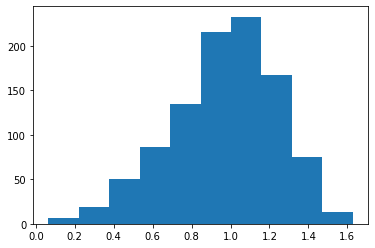

In [81]:
#plt.hist(gaussian_norms)
plt.hist(uniforms_norms)
# sqrt(0.5^2 *100) = expected value of 0.5^2 * 100 dimensions

# E[gaussian^2]*100 = ? 

In [47]:
uniforms_norms = np.reshape(uniforms_norms, (1000, 1))
reformat = (uniforms/uniforms_norms)
random_project = np.random.randint(2, size=(np.shape(reformat)))
# pretty useful numpy array method
np.place(random_project, random_project == 0, -1)

In [49]:
reformat *= random_project

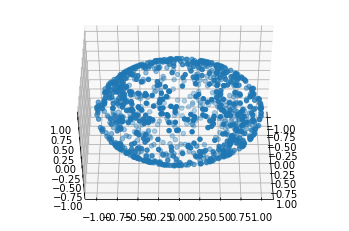

In [52]:
# only samples in one quadrant! 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=reformat[:,:1], ys=reformat[:,1:2], zs=reformat[:,2:])
# I can randomly multiple components by 1 or -1? Does this sample the damn circle finally? Is the spread going to be real? Against my real thing 
ax.view_init(45, 0)


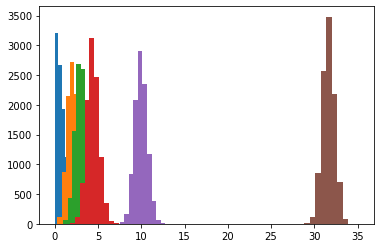

In [84]:
# try a norm comparison
dims = [1, 5, 10, 20, 100, 1000]
for d in dims:
    gauss = np.random.normal(0, 1, (10000, d))
    norms = [LA.norm(x) for x in gauss]
    plt.hist(norms)

## Looking at the robustness of our "true" variables
It looks like our 'test' as the number of distinct variables gets gobbled up depending on the dimension
What percent before it gets swallowed up? 
With more dimesions, the distance to the origin, and the distance to each other can become very close. Even though low-dimensional projections show clear separability

In [134]:
dims = [1, 2, 3, 5, 10, 20, 100, 1000]
test = 10
from scipy.spatial import distance
# distance to zero, distance to each other


for dim in dims:
    means_a = [5]*min(dim, test) + [0]*(dim-test)
    means_b = [10]*min(dim, test) + [0]*(dim-test)
    means_c = [15]*min(dim, test) + [0]*(dim-test)
    cov_a = np.identity(dim)
    a = np.random.multivariate_normal(means_a, cov_a, (100))
    b = np.random.multivariate_normal(means_b, cov_a, (100))
    c = np.random.multivariate_normal(means_c, cov_a, (100))
    ab = [distance.euclidean(x, y) for x,y in zip(a, b)]
    ac = [distance.euclidean(x, y) for x,y in zip(a, c)]
    bc = [distance.euclidean(x, y) for x,y in zip(b, c)]
    a0 = [distance.euclidean(x, 0) for x in a]
    b0 = [distance.euclidean(x, 0) for x in b]
    c0 = [distance.euclidean(x, 0) for x in c]
    print(dim, np.mean(ab), np.mean(ac), np.mean(bc), np.mean(a0), np.mean(b0), np.mean(c0))

1 5.19831084932364 10.075634093278762 4.8773232439551215 4.803978291793041 10.00228914111668 14.879612385071802
2 7.183320231868004 14.255373196655263 7.287783320792017 7.094028933842464 14.131352635146257 21.257033466630674
3 8.566220257167789 17.21801194668956 8.994949461344856 9.032056861197814 17.288302508664742 26.02055280929725
5 11.37880623871632 22.420393117896662 11.546486477665539 11.25746815846554 22.246124140711082 33.41304797799773
10 16.2044493980558 31.808160649506902 16.402255104164283 16.204771375230834 31.723375886540246 47.528269944674676
20 17.195462345554652 32.25877455053291 16.83982814575751 16.19534361728751 31.916348201230736 47.45712867091794
100 21.245247294967275 34.58758685937706 21.258422192329867 18.617605993230715 33.171708245187716 48.41196539847362
1000 47.39174236946791 54.808124817709675 47.380250017978454 35.40676754216904 44.514527260461364 56.99653037950794


In [121]:
np.shape(a)

(100, 10)

20.914683527848148

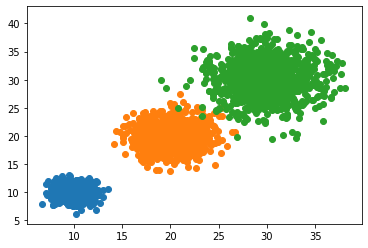

In [108]:
# only one dimension change? And it destroys it all? How about more dimension changes on the mean? seems fine. 
# what about average euclidean distance to each other?
# three separate clusters, show that in low D and in projection separable, but in high D overlaps!

a = np.random.normal(10, 1, (1000, dim))
b = np.random.normal(20, 2, (1000, dim))
c = np.random.normal(30, 3, (1000, dim))



plt.scatter(x=a[:,:1], y=a[:,1:2])
plt.scatter(x=b[:,:1], y=b[:,1:2])
plt.scatter(x=c[:,:1], y=c[:,1:2])


In [106]:
# three separate clusters, show that in low D and in projection separable, but in high D overlaps!
dim = 100
a = np.random.normal(10, 1, (1000, dim))
b = np.random.normal(20, 1, (1000, dim))
c = np.random.normal(30, 1, (1000, dim))

a_norm = [LA.norm(x) for x in a]
b_norm = [LA.norm(x) for x in b]
c_norm = [LA.norm(x) for x in c]

(array([  9.,  27.,  86., 176., 227., 236., 139.,  80.,  14.,   6.]),
 array([297.09167802, 297.71819497, 298.34471192, 298.97122887,
        299.59774581, 300.22426276, 300.85077971, 301.47729665,
        302.1038136 , 302.73033055, 303.3568475 ]),
 <a list of 10 Patch objects>)

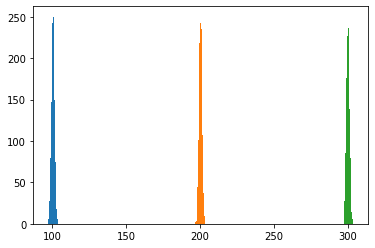

In [107]:
plt.hist(a_norm)
plt.hist(b_norm)
plt.hist(c_norm)

In [ ]:
# mass of gaussians
np.scatter(np.random.normal(0, 1, (10, 2))

In [ ]:
data = np.random.normal(0, 1, (1000))
plt.hist(data)
#plt.scatter(np.zeros(100), data)

In [ ]:
data = np.random.normal(0, 1, (1000, 2))
plt.scatter(data[:,:1], data[:,1:])

In [ ]:
import scipy.stats as st
#x, y = data[:,:1], data[:,1:]
x, y = np.random.normal(0, 2, size=100), np.random.normal(0, 1, size=100)
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

In [ ]:
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
#values = values.astype(float)
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Gaussian Kernel density estimation')

In [ ]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 35)

In [ ]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
w = ax.plot_wireframe(xx, yy, f)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Wireframe plot of Gaussian 2D KDE');

In [ ]:
# Visualize 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
data_x = np.random.normal(0, 1, (2000, 3))
ax.scatter(xs=data_x[:,:1], ys=data_x[:,1:2], zs=data_x[:,2:])

In [ ]:
# Plot a 2D histogram 
# equation for 2D 3D nD gaussians? 
# Z = f(X, Y) where X, Y, Z are random variables 
# integral f(X, Y) 

# density estimation and more. 
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(data_x[:,:1, data_x[:,:1], f, rstride=1, cstride=1, 


In [ ]:
# Visualizing manifolds!

# why do we care about NLDR?
# KNN above
    # PCA here?
    
length = 10
data_size = 100
data_x1 = np.random.randint(2, size=(data_size, 2))
data_x2 = np.random.random((data_size, length-2))*2 -1
data_x = np.concatenate((data_x1, data_x2), axis=1)
data_y = np.array([generateY(x) for x in data_x])
    
pca = PCA(n_components=3, svd_solver='arpack')
transformed = pca.fit_transform(data_x)
print(pca.explained_variance_ratio_)
# The PCs or the 

# digits rotated
    # PCs? repeatedly removing PCs?
# just digits!
# faces

In [ ]:
plt.scatter(transformed[:,:1], transformed[:,1:])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=transformed[:,:1], ys=transformed[:,1:2], zs=transformed[:,2:])